In [1]:
from pathlib import Path
import pandas as pd
from datetime import datetime
from dateutil import relativedelta
from sklearn.preprocessing import LabelEncoder

# 1) Load and merge data
agreement_path = Path('/home/engaclew/neurogen/results/agreement/agreement_file_level.csv')
children_path = Path('/home/engaclew/DATA/neurogen/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings_path = Path('/home/engaclew/DATA/neurogen/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')

agreement = pd.read_csv(agreement_path)
children = pd.read_csv(children_path)
recordings = pd.read_csv(recordings_path)

data = agreement.merge(recordings, left_on='recording_filename', right_on='recording_filename') # , how='outer'
data = data.merge(children, left_on='child_id', right_on='child_id', how='right')

# 1b) Add metrics computed by LENA & VTC
aclew_path = '/home/engaclew/neurogen/aclew_metrics.csv'
lena_path = '/home/engaclew/neurogen/lena_metrics.csv'
aclew_data = pd.read_csv(aclew_path, sep=',')
lena_data = pd.read_csv(lena_path, sep=',')
aclew_set = set(aclew_data.columns)
lena_set = set(lena_data.columns)
inter_cols = aclew_set & lena_set

metrics_data = pd.DataFrame()
for col in inter_cols:
    if aclew_data[col].dtype == 'float64':
        metrics_data[col] = (aclew_data[col] + lena_data[col])/2
    else:
        metrics_data[col] = aclew_data[col]
data = data.merge(metrics_data, on=['recording_filename', 'child_id'])

#  2) Compute age at time of recording
def diff_month(row):
    d1 = datetime.strptime(row['date_iso'], '%Y-%m-%d')
    d2 = datetime.strptime(row['child_dob'], '%Y-%m-%d')
    return (d1.year - d2.year) * 12 + d1.month - d2.month
data['age'] = data.apply(lambda row: diff_month(row), axis=1)

# 3) Excluding 'environmental_risk' and 'autism_spectrum_disorder' because we have only 2 recordings for these groups
data = data[~data['group_id'].isin(['environmental_risk', 'autism_spectrum_disorder'])]
data['group_id'] = data['group_id'].apply(lambda x: '_'+x if x != 'low_risk' else x)
data['age'] = data['age'].astype(float)

# 4) Encode categorical variables
le = LabelEncoder()
categorical_columns = ['recording_filename', 'child_id']
for col in categorical_columns:
    data[col + '_encoded'] = le.fit_transform(data[col])
## Encode child_sex and group_id in such a way that male and low_risk will be the reference groups
data['child_sex'] = pd.Categorical(data['child_sex'], categories=['m','f'])
data['group_id'] = pd.Categorical(data['group_id'], categories=['low_risk', '_angelman_syndrome', '_fragile_x_syndrome', '_down_syndrome', '_autism_sibling'])
data['duration'] /= 3600

classes = ['CHI', 'OCH', 'MAL', 'FEM', 'SIL']
for spk_class in classes:
    data[f'agreement_rate_{spk_class}'] *= 100
    data[f'kappa_{spk_class}'] *= 100
data['agreement_rate_peers'] = (data['agreement_rate_OCH'] + data['agreement_rate_MAL'] + data['agreement_rate_FEM']) / 3
data['agreement_rate_adu'] = (data['agreement_rate_MAL'] + data['agreement_rate_FEM']) / 2
data['kappa_peers'] = (data['kappa_OCH'] + data['kappa_MAL'] + data['kappa_FEM']) / 3
data['kappa_adu'] = (data['kappa_MAL'] + data['kappa_FEM']) / 2

In [4]:
data.columns

Index(['recording_filename', 'agreement_rate_CHI', 'kappa_CHI',
       'agreement_rate_OCH', 'kappa_OCH', 'agreement_rate_MAL', 'kappa_MAL',
       'agreement_rate_FEM', 'kappa_FEM', 'agreement_rate_SIL', 'kappa_SIL',
       'child_id', 'experiment_x', 'date_iso', 'start_time',
       'recording_device_type', 'duration', 'its_filename', 'experiment_y',
       'child_dob', 'child_sex', 'group_id', 'peak_1s_CTC', 'avg_voc_dur_fem',
       'voc_och_ph', 'voc_dur_fem_ph', 'avg_voc_dur_chi', 'voc_dur_mal_ph',
       '1s_CTC_ph', 'wc_fem_ph', 'voc_fem_ph', 'voc_dur_chi_ph',
       'avg_voc_dur_mal', 'voc_dur_och_ph', 'wc_mal_ph', 'avg_voc_dur_och',
       'peak_5s_CTC', 'wc_adu_ph', 'voc_chi_ph', '5s_CTC_ph', 'voc_mal_ph',
       'age', 'recording_filename_encoded', 'child_id_encoded',
       'agreement_rate_peers', 'agreement_rate_adu', 'kappa_peers',
       'kappa_adu'],
      dtype='object')

In [11]:
import statsmodels.formula.api as smf

# Age baseline
formula = 'kappa_CHI ~ 1 + avg_voc_dur_chi'
model = smf.ols(formula, data=data).fit()
print(model.summary())

#formula = 'agreement_rate_adu ~ 1 + age'
#model = smf.ols(formula, data=data).fit()
#print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              kappa_CHI   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     234.4
Date:                Wed, 04 Sep 2024   Prob (F-statistic):           1.92e-41
Time:                        08:33:51   Log-Likelihood:                -1284.7
No. Observations:                 377   AIC:                             2573.
Df Residuals:                     375   BIC:                             2581.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          13.8203      2.236     

In [13]:
# Forward selection
# Add main effect if it improves AIC (in order)
# Add interaction effects if it improves AIC (in order)
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 12, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':4, 'lines.linewidth':1})
cm = 1/2.54

def generate_interaction_terms(predictors):
    interactions = []
    
    # Generate interactions between all pairs of predictors
    for combo in combinations(predictors, 2):
        interactions.append(':'.join(combo))
    
    return interactions

def forward_selection(data, response, predictors, criterion='aic'):
    # Start with an empty model
    current_formula = f"{response} ~ 1"  # Intercept only model
    current_model = smf.ols(current_formula, data=data).fit()
    best_criterion = getattr(current_model, criterion)
    
    # Add predictor one by one only if they improve criterion
    main_effects = predictors
    interaction_terms = generate_interaction_terms(predictors)
    all_predictors = predictors + interaction_terms
    list_criterions = [best_criterion]
    list_formulas = [current_formula]
    list_rsquared = [current_model.rsquared]
    for predictor in all_predictors:
        new_formula = f"{current_formula} + {predictor}"
        new_model = smf.ols(new_formula, data=data).fit()
        new_criterion = getattr(new_model, criterion)
        
        if new_criterion < best_criterion:
            #print(f"Added {predictor}, {criterion}: {best_criterion} --> {new_criterion}")
            current_formula = new_formula
            current_model = new_model
            best_criterion = new_criterion
            list_criterions.append(best_criterion)
            list_formulas.append(current_formula)
            list_rsquared.append(current_model.rsquared)
        #else:
            #print(f"Not adding {predictor}, {criterion}: {best_criterion} --> {new_criterion}")
            
    return current_model, current_formula, list_criterions, list_formulas, list_rsquared

def print_model_summary(model):
    print(model.summary())
    
    print("\nFeature Importance (based on absolute t-values):")
    feature_importance = pd.DataFrame({
        'feature': model.params.index[1:],  # Exclude the intercept
        'importance': np.abs(model.tvalues[1:])
    })
    print(feature_importance.sort_values('importance', ascending=False))




Final Model:
kappa_CHI ~ 1 + age + avg_voc_dur_chi + age:avg_voc_dur_chi
                            OLS Regression Results                            
Dep. Variable:              kappa_CHI   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     81.45
Date:                Wed, 04 Sep 2024   Prob (F-statistic):           1.51e-40
Time:                        08:43:55   Log-Likelihood:                -1281.2
No. Observations:                 377   AIC:                             2570.
Df Residuals:                     373   BIC:                             2586.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

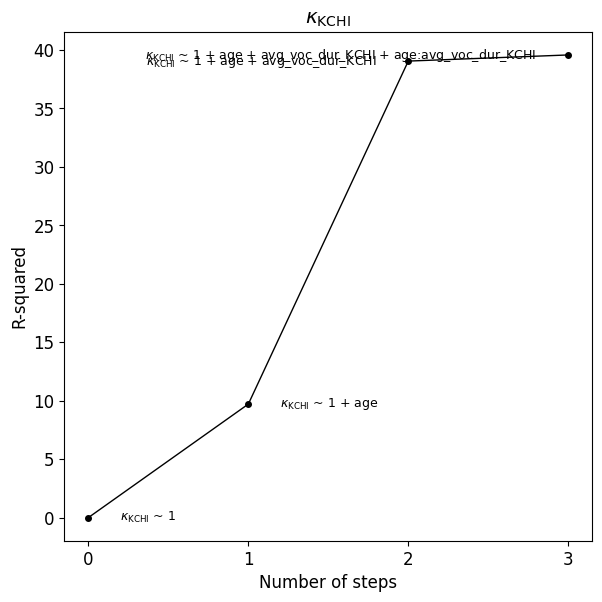

In [18]:
# Define predictors (order matters!)
predictors = [
    'age',
    'duration', 
    'C(child_sex)',
    'avg_voc_dur_chi',
    'C(group_id)',
]

# Run forward selection
final_model, final_formula, list_criterions, list_formulas, list_rsquared = forward_selection(data, 'kappa_CHI', predictors)

# Print the results
print("\nFinal Model:")
print(final_formula)
print_model_summary(final_model)
def plot_model(list_criterions, list_formulas, rsquared=False):
    dict_name = {
        'kappa_adu': r'$\kappa_{\text{adu}}$',
        'kappa_peers': r'$\kappa_{\text{peers}}$',
        'kappa_CHI': r'$\kappa_{\text{KCHI}}$',
        'agreement_rate_CHI': r'$agg_{\text{KCHI}}$',
        'agreement_rate_peers': r'$agg_{\text{peers}}$',
        'agreement_rate_adu': r'$agg_{\text{adu}}$',
        'C(child_sex)': 'sex',
        'C(group_id)': 'group',
        'age': 'age',
        'duration': 'duration',
        'avg_voc_dur_chi': 'avg_voc_dur_KCHI',
        'voc_chi_ph': 'voc_chi_ph',
        'voc_dur_chi_ph': 'voc_dur_chi_ph',
        '~': '~',
        '1': '1'
    }
    if rsquared:
        list_criterions = [100*crit for crit in list_criterions]
    to_predict = list_formulas[0].split('~')[0].strip()
    fig, ax = plt.subplots(1,1, figsize=(15*cm,15*cm), constrained_layout=True)
    plt.plot(range(len(list_criterions)), list_criterions, color='black')
    plt.scatter(range(len(list_criterions)), list_criterions, color='black')
    plt.title(dict_name[to_predict])
    plt.xlabel("Number of steps")
    if rsquared:
        plt.ylabel("R-squared")
    else:
        plt.ylabel("AIC")
    
    plt.xticks(np.arange(0, len(list_criterions), 1))

    for i, formula in enumerate(list_formulas):
        pretty_formula = f'{dict_name[to_predict]} ~'
        _, e2 = formula.split('~')
        e2 = e2.split('+')
        e2 = [e.strip() for e in e2]
        for j, e in enumerate(e2):
            print(e)
            if ':' in e:
                se1, se2 = e.split(':')
                e = f'{dict_name[se1]}:{dict_name[se2]}'
            else: 
                e = dict_name[e]
            if j == 0:
                pretty_formula += f' {e}'
            else:
                pretty_formula += f' + {e}'

        alignment='left'
        shift = .2
        if i >= len(list_criterions) // 2:
            alignment = 'right'
            shift = -.2
        plt.text(x=i+shift, y=list_criterions[i], s=pretty_formula, verticalalignment='center', horizontalalignment=alignment, fontsize=9)
        bn = 'rsquared' if rsquared else 'aic'
        plt.savefig(f'../results/agreement/{bn}_{to_predict}.png', dpi=200)
    plt.show()

plot_model(list_rsquared, list_formulas, rsquared=True)


In [15]:
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None, offset=0, alpha=1):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """
    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh
    barx = [lx+offset, lx+offset, rx-offset, rx-offset]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)
    plt.plot(barx, bary, c='black', alpha=alpha)

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs
    plt.text(*mid, text, **kwargs, alpha=alpha)

['low_risk', '_angelman_syndrome', '_fragile_x_syndrome', '_down_syndrome', '_autism_sibling']
Categories (5, object): ['low_risk', '_angelman_syndrome', '_fragile_x_syndrome', '_down_syndrome', '_autism_sibling']


/tmp/ipykernel_7153/227197469.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Y = data.groupby(X_col)[Y_col].mean()[X]
/tmp/ipykernel_7153/227197469.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Yerr = data.groupby(X_col)[Y_col].std(ddof=0)[X]
/tmp/ipykernel_7153/227197469.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(group_label.values()))
/tmp/ipykernel_7153/227197469.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of

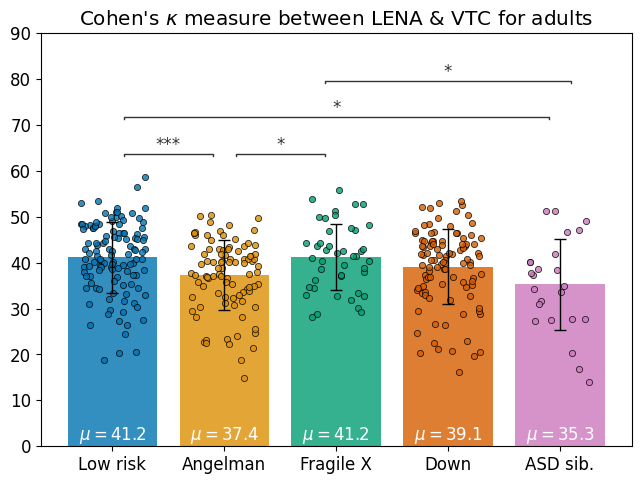

In [18]:
# Plotting kappa_chi for each group

# Analyzing data: "For N% of frames classified as K1 by vtc, LENA says K2"
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import scipy.stats as stats
from itertools import combinations

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 12, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':4, 'lines.linewidth':1})
cm = 1/2.54

# Sorting data by group
group_label = {
    'low_risk': 'Low risk',
    '_angelman_syndrome': 'Angelman',
    '_fragile_x_syndrome': 'Fragile X',
    '_down_syndrome': 'Down',
    '_autism_sibling': 'ASD sib.',
    #'environmental_risk': 'Env. risks',
    #'autism_spectrum_disorder': 'ASD',
}
y_label = {
    'kappa_CHI': "Cohen's $\kappa$ measure between LENA & VTC for KCHI",
    'agreement_rate_CHI': 'Agreement rate between LENA & VTC for KCHI (%)',
    'kappa_peers': "Cohen's $\kappa$ measure between LENA & VTC for peers",
    'agreement_rate_peers': 'Agreement rate between LENA & VTC for peers (%)',
    'kappa_adu': "Cohen's $\kappa$ measure between LENA & VTC for adults",
    'agreement_rate_adu': 'Agreement rate between LENA & VTC for adults (%)',
}

sorter_index = dict(zip(list(group_label.keys()), range(len(group_label))))
data['group_rank'] = data['group_id'].map(sorter_index)
data.sort_values(by='group_rank', inplace=True)
print(data['group_id'].unique(Y_col = 'kappa_adu'
X_col = 'group_id'

fig, ax = plt.subplots(1,1, figsize=(16*cm,12*cm), constrained_layout=True)
X = group_label.keys()
Y = data.groupby(X_col)[Y_col].mean()[X]
Yerr = data.groupby(X_col)[Y_col].std(ddof=0)[X]
ax.bar(x=X, height=Y, yerr=Yerr, color=colors, capsize=4, linewidth=2, alpha=.8)
ax.set_xticklabels(list(group_label.values()))
ax.set_title(y_label[Y_col])

# plot scatter
for idx, group_id in enumerate(group_label.keys()):
    sub_data = data[data['group_id'] == group_id]
    X = idx + np.random.uniform(-0.3, 0.3, size=len(sub_data))
    Y = sub_data[Y_col]
    plt.scatter(X,Y, color=colors[idx], edgecolor='black', linewidth=.6, s=20, alpha=.8)

plt.ylim(0, 90)
X = data[X_col].unique()
bars = np.arange(len(X))
heights = data.groupby(X_col)[Y_col].mean()[X].values
grouped_data = data.groupby('group_id')[Y_col].apply(lambda x:x.values)

combinations = [
    # dist = 1
    ('low_risk', '_autism_sibling'), ('_autism_sibling', '_angelman_syndrome'), 
    ('_angelman_syndrome', '_fragile_x_syndrome'), ('_fragile_x_syndrome', '_down_syndrome'),
    # dist = 2
    ('low_risk', '_angelman_syndrome'), ('_autism_sibling', '_fragile_x_syndrome'), ('_angelman_syndrome', '_down_syndrome'), 
    # dist = 3
    ('low_risk', '_fragile_x_syndrome'), ('_autism_sibling', '_down_syndrome'),
    # dist = 4
    ('low_risk', '_down_syndrome')]
cnt_offset = 0
y_offset = 8.0
for group1, group2 in combinations:
    res = stats.ttest_ind(grouped_data[group1], grouped_data[group2], equal_var=False)
    idx1, idx2 = np.where(X == group1)[0], np.where(X == group2)[0]
    max_y = data[Y_col].max()
    if np.abs(idx1-idx2) == 1 and res.pvalue < .05:
        heights_2 = np.asarray([max_y]*len(X))
        barplot_annotate_brackets(idx1, idx2, res.pvalue, bars, heights_2, dh=.05, barh=0.005, maxasterix=3, offset=.1, alpha=.8)
    elif np.abs(idx1-idx2) > 1 and res.pvalue < .05: 
        cnt_offset += y_offset
        heights_2 = np.asarray([max_y]*len(X)) + cnt_offset
        barplot_annotate_brackets(idx1, idx2, res.pvalue, bars, heights_2, dh=.05, barh=0.005, maxasterix=3, offset=.1, alpha=.8)

# Add mean
for idx, height in enumerate(heights):
    plt.text(x=idx, y=0, s='$\mu=%.1f$' % height, color='white', horizontalalignment='center', verticalalignment='bottom')
plt.savefig(Path('../results/agreement') / f'{Y_col}_per_{X_col}.png', dpi=300)
plt.show()

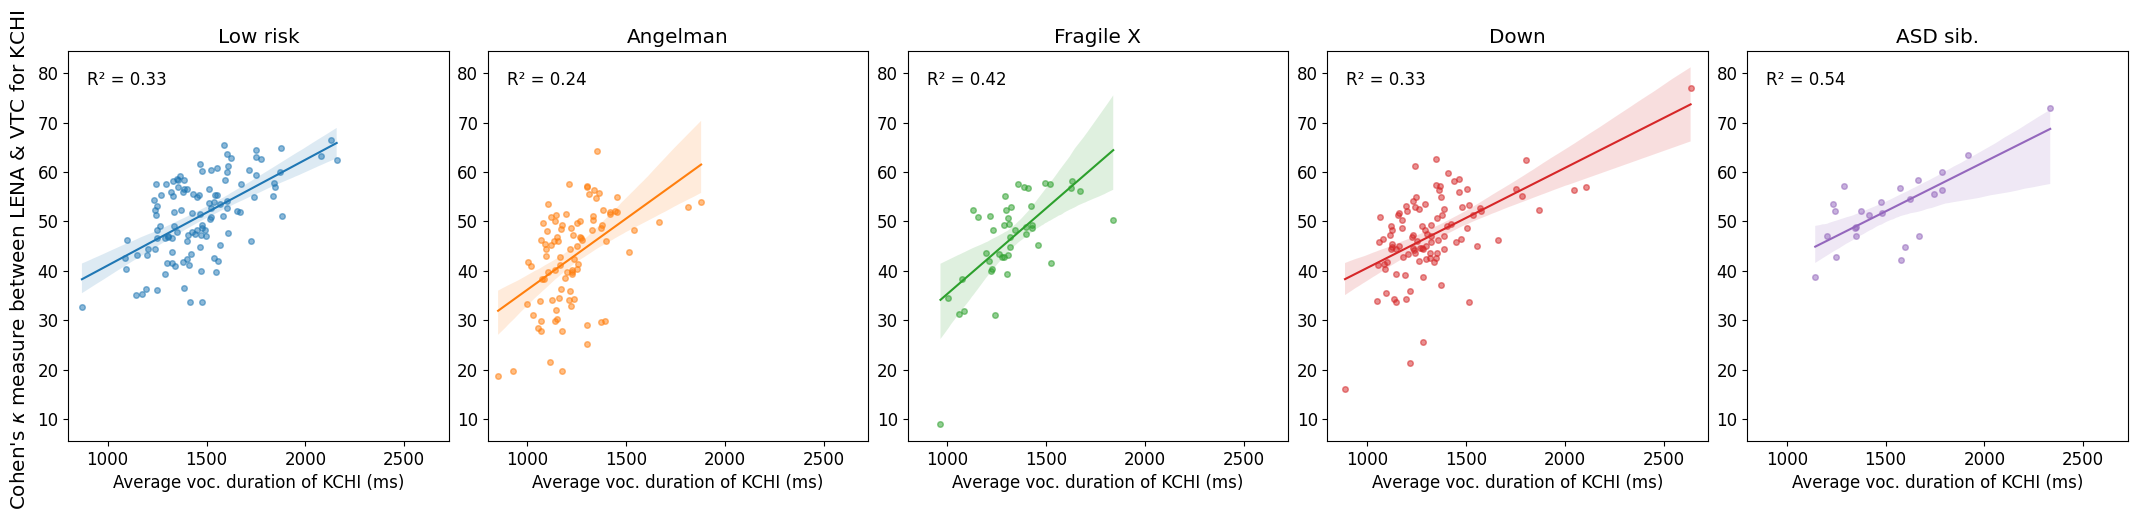

In [33]:
# Plotting kappa_chi as a function of age for each group

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import scipy.stats as stats
from itertools import combinations

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 12, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':4, 'lines.linewidth':1})
cm = 1/2.54

# Sorting data by group
group_label = {
    'low_risk': 'Low risk',
    '_angelman_syndrome': 'Angelman',
    '_fragile_x_syndrome': 'Fragile X',
    '_down_syndrome': 'Down',
    '_autism_sibling': 'ASD sib.',
    #'environmental_risk': 'Env. risks',
    #'autism_spectrum_disorder': 'ASD',
}
y_label = {
    'kappa_CHI': "Cohen's $\kappa$ measure between LENA & VTC for KCHI",
    'agreement_rate_CHI': 'Agreement rate between LENA & VTC for KCHI (%)',
    'kappa_peers': "Cohen's $\kappa$ measure between LENA & VTC for peers",
    'agreement_rate_peers': 'Agreement rate between LENA & VTC for peers (%)',
    'kappa_adu': "Cohen's $\kappa$ measure between LENA & VTC for adults",
    'agreement_rate_adu': 'Agreement rate between LENA & VTC for adults (%)',
}

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Y_col = 'kappa_CHI'
X_col = 'avg_voc_dur_chi'

fig, ax = plt.subplots(1,5, figsize=(54*cm,12*cm), constrained_layout=True)

ys_min, ys_max = [], []
xs_min, xs_max = [], []
for i, group in enumerate(group_label.keys()):
    sub_data = data[data.group_id == group]
    ax[i].scatter(sub_data[X_col], sub_data[Y_col], color=colors[i], alpha=0.3)
    # Plot regression line
    sns.regplot(x=X_col, y=Y_col, data=sub_data, ax=ax[i], 
                scatter_kws={'alpha': 0.3}, 
                line_kws={'color': colors[i]},
                color=colors[i])
    
    ax[i].set_xlabel('Average voc. duration of KCHI (ms)')
    ax[i].set_ylabel('')
    ax[i].set_title(group_label[group])
    ymin, ymax = ax[i].get_ylim()
    xmin, xmax = ax[i].get_xlim()
    ys_min.append(ymin)
    ys_max.append(ymax)
    xs_min.append(xmin)
    xs_max.append(xmax)
    
    # Calculate and display R-squared
    slope, intercept, r_value, p_value, std_err = stats.linregress(sub_data[X_col], sub_data[Y_col])
    ax[i].text(0.05, 0.95, f'R² = {r_value**2:.2f}', transform=ax[i].transAxes, 
               verticalalignment='top')

    

fig.supylabel(y_label[Y_col])
# Set equal range
ymin = np.min(ys_min)
ymax = np.max(ys_max)
xmin = np.min(xs_min)
xmax = np.max(xs_max)

for i in range(len(group_label)):
    ax[i].set_ylim(ymin, ymax)
    ax[i].set_xlim(xmin, xmax)

plt.savefig(Path('../results/agreement') / f'{Y_col}_per_{X_col}_per_group.png', dpi=300)
plt.show()

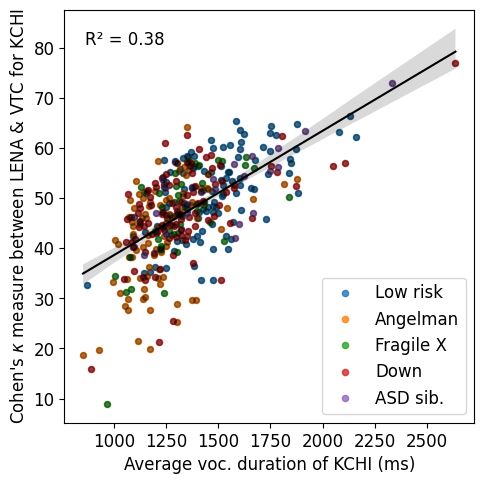

In [32]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import scipy.stats as stats
from itertools import combinations

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 12, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':4, 'lines.linewidth':1})
cm = 1/2.54

y_label = {
    'kappa_CHI': "Cohen's $\kappa$ measure between LENA & VTC for KCHI",
    'agreement_rate_CHI': 'Agreement rate between LENA & VTC for KCHI (%)',
    'kappa_peers': "Cohen's $\kappa$ measure between LENA & VTC for peers",
    'agreement_rate_peers': 'Agreement rate between LENA & VTC for peers (%)',
    'kappa_adu': "Cohen's $\kappa$ measure between LENA & VTC for adults",
    'agreement_rate_adu': 'Agreement rate between LENA & VTC for adults (%)',
}

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Y_col = 'kappa_CHI'
X_col = 'avg_voc_dur_chi'

fig, ax = plt.subplots(1,1, figsize=(12*cm,12*cm), constrained_layout=True)


#ax.scatter(data[X_col], data[Y_col], color='black', alpha=0.3)
for i, group in enumerate(group_label.keys()):
    sub_data = data[data.group_id == group]
    ax.scatter(sub_data[X_col], sub_data[Y_col], color=colors[i], alpha=.8, s=20, label=group_label[group])
sns.regplot(x=X_col, y=Y_col, data=data, ax=ax, 
            scatter_kws={'alpha': 0.3}, 
            line_kws={'color': 'black'},
            color='black')

ax.set_xlabel('Average voc. duration of KCHI (ms)')
ax.set_ylabel(y_label[Y_col])
# Calculate and display R-squared
slope, intercept, r_value, p_value, std_err = stats.linregress(data[X_col], data[Y_col])
ax.text(0.05, 0.95, f'R² = {r_value**2:.2f}', transform=ax.transAxes, 
           verticalalignment='top')

plt.legend()


plt.savefig(Path('../results/agreement') / f'{Y_col}_per_{X_col}_per_group.png', dpi=300)
plt.show()

In [98]:
# Here's the code for forward selection: add predictor that minimizes AIC

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from itertools import combinations

def generate_interaction_terms(predictors):
    interactions = []
    
    # Generate interactions between all pairs of predictors
    for combo in combinations(predictors, 2):
        interactions.append(':'.join(combo))
    
    return interactions

def forward_selection(data, response, predictors, criterion='aic'):
    # Start with an empty model
    current_formula = f"{response} ~ 1"  # Intercept only model
    current_model = smf.ols(current_formula, data=data).fit()
    best_criterion = getattr(current_model, criterion)
    
    # Add main effects one by one
    remaining_predictors = predictors.copy()
    
    while remaining_predictors:
        best_new_term = None
        for term in remaining_predictors:
            new_formula = f"{current_formula} + {term}"
            new_model = smf.ols(new_formula, data=data).fit()
            new_criterion = getattr(new_model, criterion)
            
            if new_criterion < best_criterion:
                best_criterion = new_criterion
                best_new_term = term
        
        if best_new_term:
            current_formula += f" + {best_new_term}"
            remaining_predictors.remove(best_new_term)
            print(f"Added {best_new_term}, {criterion}: {best_criterion}")
        else:
            break
    
    # Generate interaction terms after main effects are added
    interaction_terms = generate_interaction_terms(predictors)
    
    # Add interaction terms one by one
    while interaction_terms:
        best_new_term = None
        for term in interaction_terms:
            new_formula = f"{current_formula} + {term}"
            new_model = smf.ols(new_formula, data=data).fit()
            new_criterion = getattr(new_model, criterion)
            
            if new_criterion < best_criterion:
                best_criterion = new_criterion
                best_new_term = term
        
        if best_new_term:
            current_formula += f" + {best_new_term}"
            interaction_terms.remove(best_new_term)
            print(f"Added {best_new_term}, {criterion}: {best_criterion}")
        else:
            break
    
    final_model = smf.ols(current_formula, data=data).fit()
    return final_model, current_formula

def print_model_summary(model):
    print(model.summary())
    
    print("\nFeature Importance (based on absolute t-values):")
    feature_importance = pd.DataFrame({
        'feature': model.params.index[1:],  # Exclude the intercept
        'importance': np.abs(model.tvalues[1:])
    })
    print(feature_importance.sort_values('importance', ascending=False))

# Define your predictors, including 'child_sex'
predictors = [
    'duration', 
    'age', 
    'C(child_sex)', 
    'C(group_id)'
]

# Run forward selection
final_model, final_formula = forward_selection(data, 'kappa_peers', predictors)

# Print the results
print("\nFinal Model:")
print(final_formula)
print_model_summary(final_model)


Added age, aic: 2469.1994963450825
Added C(child_sex), aic: 2463.708064269413
Added duration, aic: 2458.073955155094

Final Model:
kappa_peers ~ 1 + age + C(child_sex) + duration
                            OLS Regression Results                            
Dep. Variable:            kappa_peers   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     10.01
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           2.34e-06
Time:                        14:40:29   Log-Likelihood:                -1225.0
No. Observations:                 377   AIC:                             2458.
Df Residuals:                     373   BIC:                             2474.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef   


Final Model:
kappa_CHI ~ 1 + age + avg_voc_dur_chi + age:avg_voc_dur_chi
                            OLS Regression Results                            
Dep. Variable:              kappa_CHI   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     81.45
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           1.51e-40
Time:                        10:15:53   Log-Likelihood:                -1281.2
No. Observations:                 377   AIC:                             2570.
Df Residuals:                     373   BIC:                             2586.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

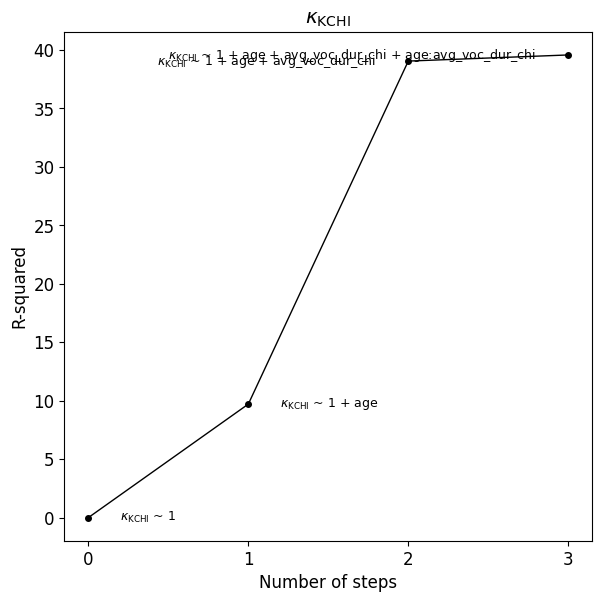

In [39]:
predictors = [
    'age',
    'duration', 
    'C(child_sex)',
    'avg_voc_dur_chi', # voc_dur_chi_ph, voc_chi_ph
    'C(group_id)',
]

# Run forward selection
final_model, final_formula, list_criterions, list_formulas, list_rsquared = forward_selection(data, 'kappa_CHI', predictors)

# Print the results
print("\nFinal Model:")
print(final_formula)
print_model_summary(final_model)
def plot_model(list_criterions, list_formulas, rsquared=False):
    dict_name = {
        'kappa_adu': r'$\kappa_{\text{adu}}$',
        'kappa_peers': r'$\kappa_{\text{peers}}$',
        'kappa_CHI': r'$\kappa_{\text{KCHI}}$',
        'agreement_rate_CHI': r'$agg_{\text{KCHI}}$',
        'agreement_rate_peers': r'$agg_{\text{peers}}$',
        'agreement_rate_adu': r'$agg_{\text{adu}}$',
        'C(child_sex)': 'sex',
        'C(group_id)': 'group',
        'age': 'age',
        'duration': 'duration',
        'avg_voc_dur_chi': 'avg_voc_dur_chi',
        'voc_dur_chi_ph': 'voc_dur_chi_ph', 
        'voc_chi_ph': 'voc_chi_ph', 
        '~': '~',
        '1': '1'
    }
    if rsquared:
        list_criterions = [100*crit for crit in list_criterions]
    to_predict = list_formulas[0].split('~')[0].strip()
    fig, ax = plt.subplots(1,1, figsize=(15*cm,15*cm), constrained_layout=True)
    plt.plot(range(len(list_criterions)), list_criterions, color='black')
    plt.scatter(range(len(list_criterions)), list_criterions, color='black')
    plt.title(dict_name[to_predict])
    plt.xlabel("Number of steps")
    if rsquared:
        plt.ylabel("R-squared")
    else:
        plt.ylabel("AIC")
    
    plt.xticks(np.arange(0, len(list_criterions), 1))

    for i, formula in enumerate(list_formulas):
        pretty_formula = f'{dict_name[to_predict]} ~'
        _, e2 = formula.split('~')
        e2 = e2.split('+')
        e2 = [e.strip() for e in e2]
        for j, e in enumerate(e2):
            print(e)
            if ':' in e:
                se1, se2 = e.split(':')
                e = f'{dict_name[se1]}:{dict_name[se2]}'
            else: 
                e = dict_name[e]
            if j == 0:
                pretty_formula += f' {e}'
            else:
                pretty_formula += f' + {e}'

        alignment='left'
        shift = .2
        if i >= len(list_criterions) // 2:
            alignment = 'right'
            shift = -.2
        plt.text(x=i+shift, y=list_criterions[i], s=pretty_formula, verticalalignment='center', horizontalalignment=alignment, fontsize=9)
        bn = 'rsquared' if rsquared else 'aic'
        plt.savefig(f'../results/agreement/{bn}_{to_predict}.png', dpi=200)
    plt.show()

plot_model(list_rsquared, list_formulas, rsquared=True)


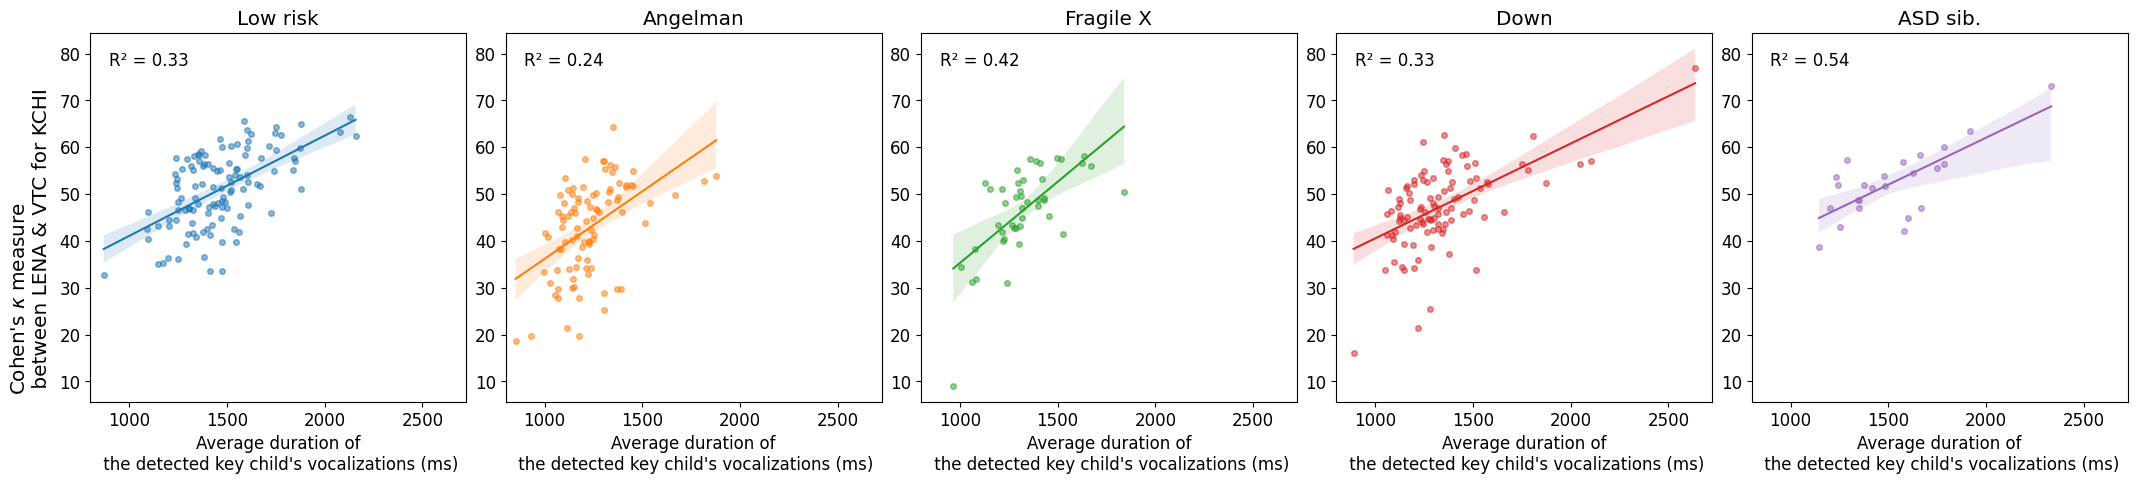

In [49]:
# Plotting kappa_chi as a function of age for each group

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import scipy.stats as stats
from itertools import combinations

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 12, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':4, 'lines.linewidth':1})
cm = 1/2.54

# Sorting data by group
group_label = {
    'low_risk': 'Low risk',
    '_angelman_syndrome': 'Angelman',
    '_fragile_x_syndrome': 'Fragile X',
    '_down_syndrome': 'Down',
    '_autism_sibling': 'ASD sib.',
    #'environmental_risk': 'Env. risks',
    #'autism_spectrum_disorder': 'ASD',
}
y_label = {
    'kappa_CHI': "Cohen's $\kappa$ measure\n between LENA & VTC for KCHI",
    'agreement_rate_CHI': 'Agreement rate between LENA & VTC for KCHI (%)',
    'kappa_peers': "Cohen's $\kappa$ measure\n between LENA & VTC for peers",
    'agreement_rate_peers': 'Agreement rate between LENA & VTC for peers (%)',
    'kappa_adu': "Cohen's $\kappa$ measure\n between LENA & VTC for adults",
    'agreement_rate_adu': 'Agreement rate between LENA & VTC for adults (%)',
}

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Y_col = 'kappa_CHI'
X_col = 'avg_voc_dur_chi'

fig, ax = plt.subplots(1,5, figsize=(54*cm,12*cm), constrained_layout=True)

ys_min, ys_max = [], []
xs_min, xs_max = [], []
for i, group in enumerate(group_label.keys()):
    sub_data = data[data.group_id == group]
    ax[i].scatter(sub_data[X_col], sub_data[Y_col], color=colors[i], alpha=0.3)
    # Plot regression line
    sns.regplot(x=X_col, y=Y_col, data=sub_data, ax=ax[i], 
                scatter_kws={'alpha': 0.3}, 
                line_kws={'color': colors[i]},
                color=colors[i])
    
    ax[i].set_xlabel("Average duration of\n the detected key child's vocalizations (ms)")
    ax[i].set_ylabel('')
    ax[i].set_title(group_label[group])
    ymin, ymax = ax[i].get_ylim()
    xmin, xmax = ax[i].get_xlim()
    ys_min.append(ymin)
    ys_max.append(ymax)
    xs_min.append(xmin)
    xs_max.append(xmax)
    
    # Calculate and display R-squared
    slope, intercept, r_value, p_value, std_err = stats.linregress(sub_data[X_col], sub_data[Y_col])
    ax[i].text(0.05, 0.95, f'R² = {r_value**2:.2f}', transform=ax[i].transAxes, 
               verticalalignment='top')

    

fig.supylabel(y_label[Y_col])
# Set equal range
ymin = np.min(ys_min)
ymax = np.max(ys_max)
xmin = np.min(xs_min)
xmax = np.max(xs_max)

for i in range(len(group_label)):
    ax[i].set_ylim(ymin, ymax)
    ax[i].set_xlim(xmin, xmax)

plt.savefig(Path('../results/agreement') / f'{Y_col}_per_{X_col}_per_group.png', dpi=300)
plt.show()

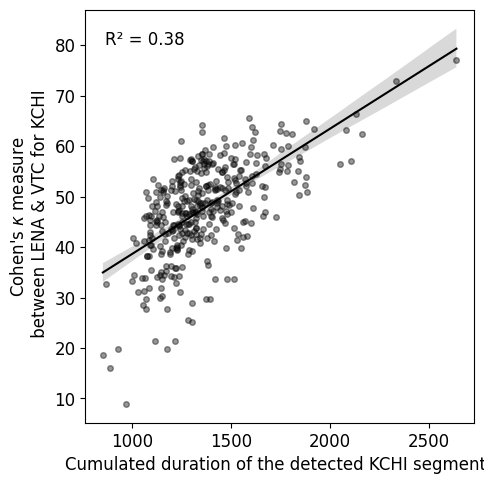

In [91]:

Y_col = 'kappa_CHI'
X_col = 'avg_voc_dur_chi'

fig, ax = plt.subplots(1,1, figsize=(12*cm,12*cm), constrained_layout=True)
ax.scatter(data[X_col], data[Y_col], color='grey', alpha=0.3)
sns.regplot(x=X_col, y=Y_col, data=data, ax=ax, 
                scatter_kws={'alpha': 0.3}, color='black')
slope, intercept, r_value, p_value, std_err = stats.linregress(data[X_col], data[Y_col])
ax.text(0.05, 0.95, f'R² = {r_value**2:.2f}', transform=ax.transAxes, 
           verticalalignment='top')
ax.set_xlabel("Cumulated duration of the detected KCHI segments")
ax.set_ylabel(y_label[Y_col])
plt.savefig(Path('../results/agreement') / f'{Y_col}_per_{X_col}.png', dpi=300)
plt.show()

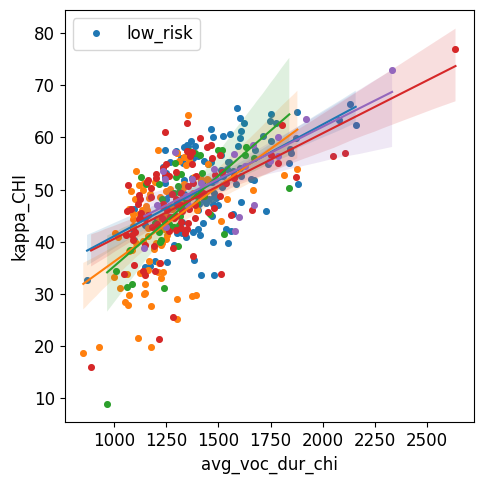

In [94]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import scipy.stats as stats
from itertools import combinations

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 12, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':4, 'lines.linewidth':1})
cm = 1/2.54

# Sorting data by group
group_label = {
    'low_risk': 'Low risk',
    '_angelman_syndrome': 'Angelman',
    '_fragile_x_syndrome': 'Fragile X',
    '_down_syndrome': 'Down',
    '_autism_sibling': 'ASD sib.',
    #'environmental_risk': 'Env. risks',
    #'autism_spectrum_disorder': 'ASD',
}
y_label = {
    'kappa_CHI': "Cohen's $\kappa$ measure\n between LENA & VTC for KCHI",
    'agreement_rate_CHI': 'Agreement rate between LENA & VTC for KCHI (%)',
    'kappa_peers': "Cohen's $\kappa$ measure\n between LENA & VTC for peers",
    'agreement_rate_peers': 'Agreement rate between LENA & VTC for peers (%)',
    'kappa_adu': "Cohen's $\kappa$ measure\n between LENA & VTC for adults",
    'agreement_rate_adu': 'Agreement rate between LENA & VTC for adults (%)',
}

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Y_col = 'kappa_CHI'
X_col = 'avg_voc_dur_chi'

fig, ax = plt.subplots(1,1, figsize=(12*cm,12*cm), constrained_layout=True)

ys_min, ys_max = [], []
xs_min, xs_max = [], []
for i, group in enumerate(group_label.keys()):
    sub_data = data[data.group_id == group]
    ax.scatter(sub_data[X_col], sub_data[Y_col], color=colors[i], label=group)
    sns.regplot(x=X_col, y=Y_col, data=sub_data, ax=ax, 
                scatter_kws={'alpha': 0.3}, 
                line_kws={'color': colors[i]},
                color=colors[i])
plt.legend() 

#plt.savefig(Path('../results/agreement') / f'{Y_col}_per_{X_col}_per_group.png', dpi=300)
plt.show()

In [2]:
# Summary statistics for SCSB proposal
from pathlib import Path
import pandas as pd
from datetime import datetime
from dateutil import relativedelta
from sklearn.preprocessing import LabelEncoder

# 1) Load and merge data
agreement_path = Path('/home/engaclew/neurogen/results/agreement/agreement_file_level.csv')
children_path = Path('/home/engaclew/DATA/neurogen/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings_path = Path('/home/engaclew/DATA/neurogen/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')

agreement = pd.read_csv(agreement_path)
children = pd.read_csv(children_path)
recordings = pd.read_csv(recordings_path)

data = agreement.merge(recordings, left_on='recording_filename', right_on='recording_filename') # , how='outer'
data = data.merge(children, left_on='child_id', right_on='child_id', how='right')

# 1b) Add metrics computed by LENA & VTC
aclew_path = '/home/engaclew/neurogen/aclew_metrics.csv'
lena_path = '/home/engaclew/neurogen/lena_metrics.csv'
aclew_data = pd.read_csv(aclew_path, sep=',')
lena_data = pd.read_csv(lena_path, sep=',')
aclew_set = set(aclew_data.columns)
lena_set = set(lena_data.columns)
inter_cols = aclew_set & lena_set

metrics_data = pd.DataFrame()
for col in inter_cols:
    if aclew_data[col].dtype == 'float64':
        metrics_data[col] = (aclew_data[col] + lena_data[col])/2
    else:
        metrics_data[col] = aclew_data[col]
data = data.merge(metrics_data, on=['recording_filename', 'child_id'])

#  2) Compute age at time of recording
def diff_month(row):
    d1 = datetime.strptime(row['date_iso'], '%Y-%m-%d')
    d2 = datetime.strptime(row['child_dob'], '%Y-%m-%d')
    return (d1.year - d2.year) * 12 + d1.month - d2.month
data['age'] = data.apply(lambda row: diff_month(row), axis=1)

In [12]:
order_dict = {
    'low_risk': 0, 
    'angelman_syndrome': 1, 
    'fragile_x_syndrome': 2, 
    'down_syndrome': 3, 
    'autism_sibling': 4,
    'autism_spectrum_disorder': 5, 
    'environmental_risk': 6
}

data = data.sort_values(by='group_id', key=lambda col: col.map(order_dict))
data.groupby('group_id').count()

,recording_filename,agreement_rate_CHI,kappa_CHI,agreement_rate_OCH,kappa_OCH,agreement_rate_MAL,kappa_MAL,agreement_rate_FEM,kappa_FEM,agreement_rate_SIL,...,peak_5s_CTC,1s_CTC_ph,voc_fem_ph,voc_dur_chi_ph,voc_och_ph,wc_fem_ph,wc_mal_ph,voc_dur_och_ph,avg_voc_dur_chi,age
group_id,,,,,,,,,,,,,,,,,,,,,
angelman_syndrome,92,92,92,92,92,92,92,92,92,92,...,91,92,92,92,92,92,92,92,92,92
autism_sibling,24,24,24,24,24,24,24,24,24,24,...,23,24,24,24,24,24,24,24,24,24
autism_spectrum_disorder,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
down_syndrome,101,101,101,101,101,101,101,101,101,101,...,101,101,101,101,101,101,101,101,101,101
environmental_risk,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
fragile_x_syndrome,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
low_risk,116,116,116,116,116,116,116,116,116,116,...,115,116,116,116,116,116,116,116,116,116


In [19]:
data.groupby('group_id')['child_id'].nunique()

group_id
angelman_syndrome           53
autism_sibling              23
autism_spectrum_disorder     2
down_syndrome               50
environmental_risk           2
fragile_x_syndrome          26
low_risk                    72
Name: child_id, dtype: int64

In [22]:
# Get min and max age for each group
age_range = data.groupby('group_id')['age'].agg(['min', 'max'])
age_range

,min,max
group_id,,
angelman_syndrome,7,67
autism_sibling,4,31
autism_spectrum_disorder,25,43
down_syndrome,5,66
environmental_risk,41,62
fragile_x_syndrome,7,81
low_risk,3,28


In [24]:
# Count recordings per child first
recordings_per_child = data.groupby(['group_id', 'child_id'])['recording_filename'].count()

# Then get the mean number of recordings per child for each group
avg_recordings_per_group = recordings_per_child.groupby('group_id').mean()
avg_recordings_per_group


group_id
angelman_syndrome           1.735849
autism_sibling              1.043478
autism_spectrum_disorder    1.000000
down_syndrome               2.020000
environmental_risk          1.000000
fragile_x_syndrome          1.692308
low_risk                    1.611111
Name: recording_filename, dtype: float64

In [28]:
total_duration = data.groupby('group_id')['duration'].sum() / (1000 * 60 * 60)
total_duration

group_id
angelman_syndrome           1231.483018
autism_sibling               310.797430
autism_spectrum_disorder      32.000000
down_syndrome               1394.810743
environmental_risk            32.000000
fragile_x_syndrome           600.222446
low_risk                    1570.966609
Name: duration, dtype: float64

In [33]:
len(data['child_id'].unique())

228